In [1]:
# This generator is intended to generate
# sequences with specified data distributions.

In [58]:
# Support sequence generations:

# Token:
# STRING
# INT

# Token frequency distributions:
# RANDOM
# ZIPF
# NORM
# BINOM

# Pattern level:
# N_GRAM

# Tasks:
# SUM (INT)
# MEDIAN (INT)
# MID_TOKEN (STRING, INT)

In [63]:
import numpy as np
import pandas as pd
import random
from scipy import special, stats
from constants import *
import matplotlib.pyplot as plt
from collections import Counter
from functools import partial
%matplotlib inline

In [66]:
class SeqLego:
    def __init__(self):
        pass
    
    def sum_game(self, dist_seq):
        return sum(dist_seq)

    def avg_game(self, dist_seq):
        return sum(dist_seq)*1./len(dist_seq)
    
    def mid_token_game(self, dist_seq):
        pass
    
    def median_game(self, dist_seq):
        pass

class DistSeq:
    def __init__(self, max_token=50265, 
                 max_seq_len=32, avg_seq_len=16, min_seq_len=8,
                 seq_len_dist="random",
                 vocab_file=None, 
                 game_name="SUM"):
        self.max_token = max_token
        self.max_seq_len = max_seq_len
        self.avg_seq_len = avg_seq_len
        self.min_seq_len = min_seq_len
        self.seq_len_dist = seq_len_dist
    
        if vocab_file == None:
            self.tokens_list = np.arange(1, self.max_token+1)
        else:
            print("loading existing vocab: ", vocab_file)
            # if a vocab is provided, we sampled from the vocab
            load_vocab = load_bert_vocab(vocab_file)
            words_list = [key for key in local_vocab.keys()]
            self.tokens_list = random.choices(words_list, k=self.max_token)
        self.vocab_idx = np.arange(1, self.max_token+1)
        self.vocab = dict(zip(self.vocab_idx, self.tokens_list))

        # zipf       
        zipf_a = 1.01
        self.zipf_prob = self.vocab_idx**(-zipf_a) / special.zetac(zipf_a)
        np.random.shuffle(self.zipf_prob)
        
        # uniform
        self.uniform_prob = [(1. / len(self.vocab_idx)) for _ in range(len(self.vocab_idx))]
        np.random.shuffle(self.uniform_prob)
        
        # normal
        norm_x = np.linspace(-3.0, 3.0, num=len(self.vocab_idx)) # make this fake x
        self.normal_prob = stats.norm(0, 1).pdf(norm_x) # assume mean=0;var=1
        np.random.shuffle(self.normal_prob)
        
        # game name
        self.game_name = game_name
        if self.game_name == "SUM":
            self.game = partial(SeqLego().sum_game)  

    def to_json(self, dist_seqs, seq_labels, dist_name):
        d = {'sentence': dist_seqs, 'gold_label': seq_labels}
        df = pd.DataFrame(data=d)
        out_filename = f"game-{self.game_name}-{dist_name}-dist-{len(dist_seqs)}-seq.jsonl"
        df.to_json(os.path.join(data_files_dirname, out_filename), 
                   orient="records", lines=True)

    def uniform(self, k=100, output=False):
        dist_seqs = []
        seq_labels = []
        for _ in range(k):
            seq_len = random.randint(self.min_seq_len, self.max_seq_len)
            dist_seq = random.choices(self.vocab_idx, self.uniform_prob, k=seq_len)
            dist_seqs.append([self.vocab[_id] for _id in dist_seq])
            seq_labels.append(self.game(dist_seq))
        if output:
            self.to_json(dist_seqs, seq_labels, "uniform")
        return dist_seqs, seq_labels
    
    def zipf(self, k=100, output=False):
        dist_seqs = []
        seq_labels = []
        for _ in range(k):
            seq_len = random.randint(self.min_seq_len, self.max_seq_len)
            dist_seq = random.choices(self.vocab_idx, self.zipf_prob, k=seq_len)
            dist_seqs.append([self.vocab[_id] for _id in dist_seq])
            seq_labels.append(self.game(dist_seq))
        if output:
            self.to_json(dist_seqs, seq_labels, "zipf")
        return dist_seqs, seq_labels

    def norm(self, k=100, output=False):
        dist_seqs = []
        seq_labels = []
        for _ in range(k):
            seq_len = random.randint(self.min_seq_len, self.max_seq_len)
            dist_seq = random.choices(self.vocab_idx, self.normal_prob, k=seq_len)
            dist_seqs.append([self.vocab[_id] for _id in dist_seq])
            seq_labels.append(self.game(dist_seq))
        if output:
            self.to_json(dist_seqs, seq_labels, "norm")
        return dist_seqs, seq_labels
    
    def visualize_vocab_dist(self, dist_seqs):
        flatten_dist_seqs = [j for sub in dist_seqs for j in sub]
        counter_dist_seqs = Counter(flatten_dist_seqs)
        
        labels, values = zip(*counter_dist_seqs.items())
        indSort = np.argsort(values)[::-1]
        labels = np.array(labels)[indSort]
        values = np.array(values)[indSort]
        indexes = np.arange(len(labels))

        bar_width = 0.35
        plt.rcParams['axes.facecolor'] = 'white'
        plt.rcParams['axes.edgecolor'] = "black"
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.tight_layout()
        plt.grid(color='black', linestyle='-.')
        plt.bar(indexes, values, color="r", alpha=0.5)
        plt.title('Sorted Frequency Histogram')
        plt.show()

In [76]:
dsg = DistSeq(max_token=1000, vocab_file=bert_vocab_path)

loading existing vocab:  ../data_files/bert_vocab.txt


In [81]:
sampled_seqs, sampled_label = dsg.zipf(k=10000, output=True)

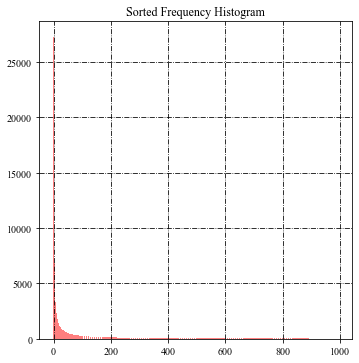

In [82]:
dsg.visualize_vocab_dist(sampled_seqs)